# XGBoost

In [7]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

cn_df = pd.read_csv('train_data/cn_price_score.csv')
us_df = pd.read_csv('train_data/us_price_score.csv')

for df in [cn_df, us_df]:
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df['sentiment_lag1'] = df['sentiment_score'].shift(1)

lags = [1, 2, 3, 4, 5, 10, 15, 20]

def create_features(df, use_sentiment=True):
    df = df.copy()
    for lag in lags:
        df[f'price_lag_{lag}'] = df['Price'].shift(lag)
    if use_sentiment:
        features = [f'price_lag_{lag}' for lag in lags] + ['sentiment_lag1']
    else:
        features = [f'price_lag_{lag}' for lag in lags]
    
    df['target_price'] = df['Price'].shift(-1)
    df = df.dropna(subset=features + ['target_price'])

    X = df[features]
    y = df['target_price']
    return X, y

def train_eval_split(X, y, ratio=0.8):
    split_idx = int(len(X) * ratio)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    model = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return {
        "model": model,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(np.mean((y_test - preds) ** 2)),
        "R2": r2_score(y_test, preds)
    }

X_cn_nosent, y_cn_nosent = create_features(cn_df, use_sentiment=False)
X_cn_sent, y_cn_sent = create_features(cn_df, use_sentiment=True)

X_us_nosent, y_us_nosent = create_features(us_df, use_sentiment=False)
X_us_sent, y_us_sent = create_features(us_df, use_sentiment=True)

results = [
    {"Country": "China", "Model": "No Sentiment", **train_eval_split(X_cn_nosent, y_cn_nosent)},
    {"Country": "China", "Model": "With Sentiment", **train_eval_split(X_cn_sent, y_cn_sent)},
    {"Country": "US", "Model": "No Sentiment", **train_eval_split(X_us_nosent, y_us_nosent)},
    {"Country": "US", "Model": "With Sentiment", **train_eval_split(X_us_sent, y_us_sent)},
]

results_df = pd.DataFrame(results)[["Country", "Model", "MAE", "RMSE", "R2"]]
print(results_df)

  Country           Model         MAE        RMSE        R2
0   China    No Sentiment   53.878147   64.982138  0.116434
1   China  With Sentiment   47.287635   58.780469  0.277035
2      US    No Sentiment  116.439393  154.656809 -1.264104
3      US  With Sentiment  106.162606  141.269175 -0.889092


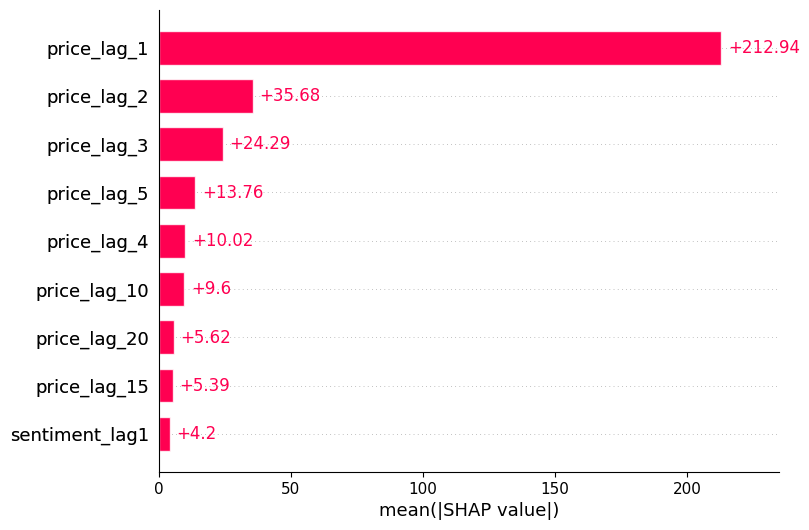

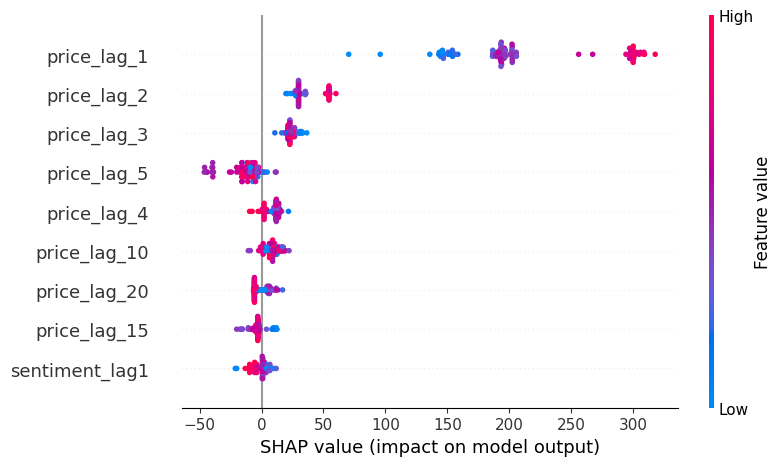

In [8]:
import shap
import matplotlib.pyplot as plt

X_cn_sent, y_cn_sent = create_features(cn_df, use_sentiment=True)

split_idx = int(len(X_cn_sent) * 0.8)
X_train = X_cn_sent.iloc[:split_idx]
y_train = y_cn_sent.iloc[:split_idx]
X_test = X_cn_sent.iloc[split_idx:]
y_test = y_cn_sent.iloc[split_idx:]

xgb_model = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.plots.bar(shap_values, max_display=10)

shap.plots.beeswarm(shap_values, max_display=10)


# Random Forest

In [3]:
from sklearn.ensemble import RandomForestRegressor

def train_eval_rf(X, y, ratio=0.8):
    split_idx = int(len(X) * ratio)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return {
        "model": model,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(np.mean((y_test - preds) ** 2)),
        "R2": r2_score(y_test, preds)
    }

X_cn_nosent, y_cn_nosent = create_features(cn_df, use_sentiment=False)
X_cn_sent, y_cn_sent = create_features(cn_df, use_sentiment=True)
X_us_nosent, y_us_nosent = create_features(us_df, use_sentiment=False)
X_us_sent, y_us_sent = create_features(us_df, use_sentiment=True)

results = [
    {"Country": "China", "Model": "RF No Sentiment", **train_eval_rf(X_cn_nosent, y_cn_nosent)},
    {"Country": "China", "Model": "RF With Sentiment", **train_eval_rf(X_cn_sent, y_cn_sent)},
    {"Country": "US", "Model": "RF No Sentiment", **train_eval_rf(X_us_nosent, y_us_nosent)},
    {"Country": "US", "Model": "RF With Sentiment", **train_eval_rf(X_us_sent, y_us_sent)},
]

results_df = pd.DataFrame(results)[["Country", "Model", "MAE", "RMSE", "R2"]]
print(results_df)

  Country              Model        MAE        RMSE        R2
0   China    RF No Sentiment  51.100118   62.496086  0.182747
1   China  RF With Sentiment  49.710406   62.604946  0.179897
2      US    RF No Sentiment  96.978457  129.773144 -0.594145
3      US  RF With Sentiment  96.124375  128.701986 -0.567937


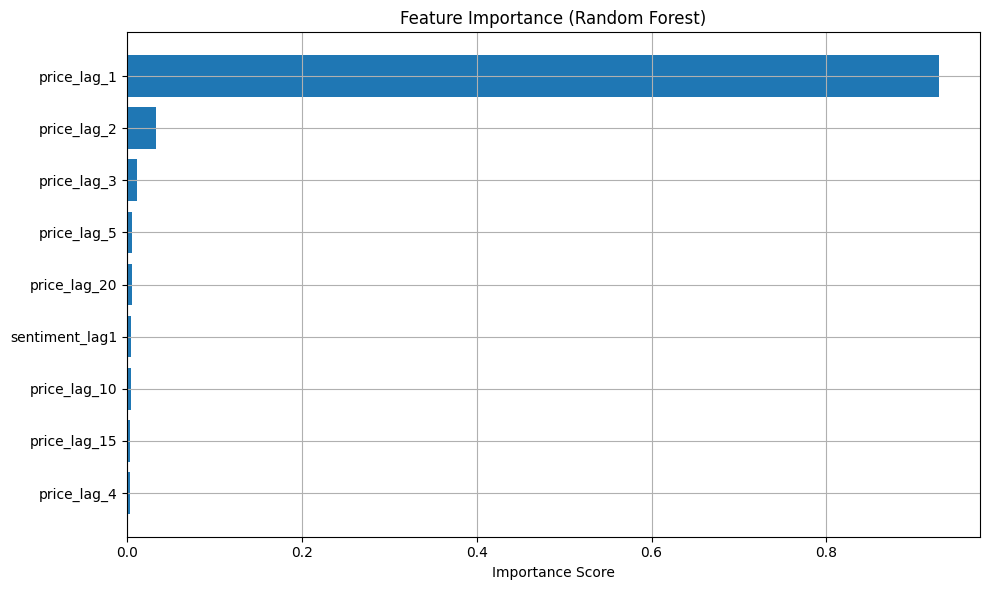

In [4]:
X_cn_sent, y_cn_sent = create_features(cn_df, use_sentiment=True)
split_idx = int(len(X_cn_sent) * 0.8)
X_train = X_cn_sent.iloc[:split_idx]
y_train = y_cn_sent.iloc[:split_idx]
X_test = X_cn_sent.iloc[split_idx:]

model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
model.fit(X_train, y_train)


importances = model.feature_importances_
feature_names = X_train.columns
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importances_df["Feature"], importances_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()


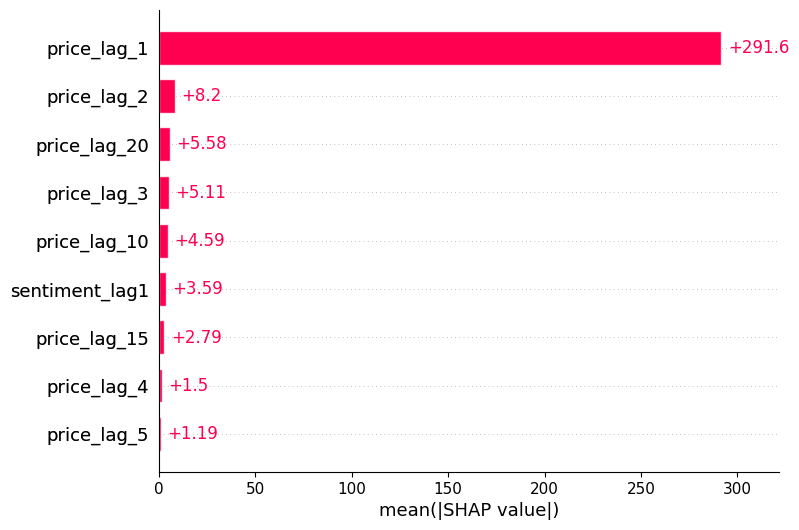

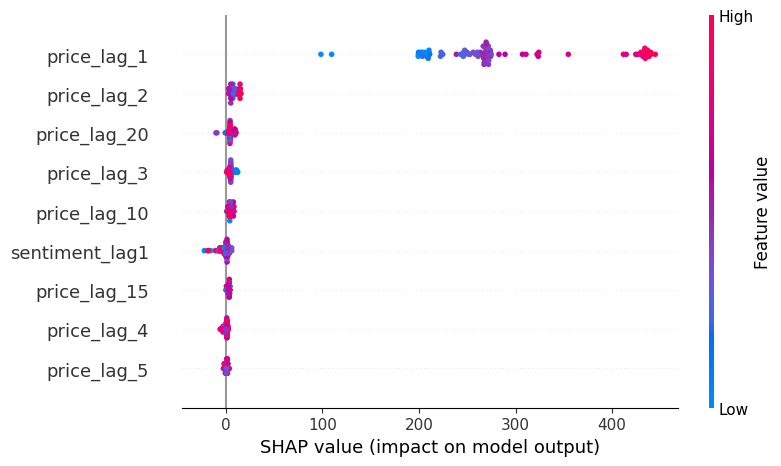

In [5]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.plots.bar(shap_values, max_display=10)

shap.plots.beeswarm(shap_values, max_display=10)

# VAR

In [ ]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

cn_var_df = cn_df[['date', 'Price', 'sentiment_score']].copy()
us_var_df = us_df[['date', 'Price', 'sentiment_score']].copy()

cn_var_df['date'] = pd.to_datetime(cn_var_df['date'])
us_var_df['date'] = pd.to_datetime(us_var_df['date'])

cn_var_df.set_index('date', inplace=True)
us_var_df.set_index('date', inplace=True)

cn_var_df.dropna(inplace=True)
us_var_df.dropna(inplace=True)

cn_model = VAR(cn_var_df)
cn_fitted = cn_model.fit(maxlags=15, ic='aic')

us_model = VAR(us_var_df)
us_fitted = us_model.fit(maxlags=15, ic='aic')

cn_gc_test = grangercausalitytests(cn_var_df[['Price', 'sentiment_score']], maxlag=5, verbose=False)
us_gc_test = grangercausalitytests(us_var_df[['Price', 'sentiment_score']], maxlag=5, verbose=False)

def extract_gc_pvals(gc_result):
    return {lag: round(gc_result[lag][0]['ssr_ftest'][1], 4) for lag in gc_result}

{
    "China Granger p-values": extract_gc_pvals(cn_gc_test),
    "US Granger p-values": extract_gc_pvals(us_gc_test)
}


/Users/mingyu.wang/Downloads/personal/2025/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mingyu.wang/Downloads/personal/2025/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mingyu.wang/Downloads/personal/2025/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/mingyu.wang/Downloads/personal/2025/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{'China Granger p-values': {1: 0.3261,
  2: 0.0665,
  3: 0.1369,
  4: 0.2041,
  5: 0.2882},
 'US Granger p-values': {1: 0.3173, 2: 0.4739, 3: 0.68, 4: 0.8248, 5: 0.7151}}

# Statistical Test

In [ ]:
from scipy.stats import ttest_rel, wilcoxon

def get_errors_xgb(X, y, use_sentiment):
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    model = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return np.abs(y_test.values - preds)  

cn_err_no = get_errors(*create_features(cn_df, use_sentiment=False), use_sentiment=False)
cn_err_sent = get_errors(*create_features(cn_df, use_sentiment=True), use_sentiment=True)
us_err_no = get_errors(*create_features(us_df, use_sentiment=False), use_sentiment=False)
us_err_sent = get_errors(*create_features(us_df, use_sentiment=True), use_sentiment=True)

print("China Paired t-test:", ttest_rel(cn_err_no, cn_err_sent))
print("China Wilcoxon:", wilcoxon(cn_err_no, cn_err_sent))

print("US Paired t-test:", ttest_rel(us_err_no, us_err_sent))
print("US Wilcoxon:", wilcoxon(us_err_no, us_err_sent))


China Paired t-test: TtestResult(statistic=3.039914323766023, pvalue=0.00309860916953092, df=90)
China Wilcoxon: WilcoxonResult(statistic=1398.0, pvalue=0.005945949119763183)
US Paired t-test: TtestResult(statistic=7.792240387201678, pvalue=8.228848742670905e-12, df=95)
US Wilcoxon: WilcoxonResult(statistic=614.0, pvalue=3.7453099489531485e-10)


In [11]:
def get_rf_errors(X, y):
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return np.abs(y_test.values - preds)

cn_rf_err_no = get_rf_errors(*create_features(cn_df, use_sentiment=False))
cn_rf_err_sent = get_rf_errors(*create_features(cn_df, use_sentiment=True))
us_rf_err_no = get_rf_errors(*create_features(us_df, use_sentiment=False))
us_rf_err_sent = get_rf_errors(*create_features(us_df, use_sentiment=True))

print("RF China Paired t-test:", ttest_rel(cn_rf_err_no, cn_rf_err_sent))
print("RF China Wilcoxon:", wilcoxon(cn_rf_err_no, cn_rf_err_sent))

print("RF US Paired t-test:", ttest_rel(us_rf_err_no, us_rf_err_sent))
print("RF US Wilcoxon:", wilcoxon(us_rf_err_no, us_rf_err_sent))


RF China Paired t-test: TtestResult(statistic=1.1802892080244127, pvalue=0.24099534310238035, df=90)
RF China Wilcoxon: WilcoxonResult(statistic=1445.0, pvalue=0.010325819270792156)
RF US Paired t-test: TtestResult(statistic=2.6076389762837375, pvalue=0.010588074648791603, df=95)
RF US Wilcoxon: WilcoxonResult(statistic=1361.0, pvalue=0.0004087019843603971)
